<a href="https://colab.research.google.com/github/valebl/SSZ_Clustering/blob/main/DBSCAN_SSZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DBSCAN

In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import DBSCAN

import seaborn as sns

%config InlineBackend.figure_format = 'svg'

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/SeismicSources')

from utils import plot_shape, haversine_np, distance_np

Load the catalogue

In [100]:
filepath = "/content/drive/MyDrive/SeismicSources/CATALOGUE_FOCAL.xlsx"
df = pd.read_excel(filepath,usecols="A:N",engine="openpyxl")
df.set_index('Index',inplace=True)
df = df[['X','Y','MwDef','Year','LonDef','LatDef','EqID','rake_360']]
df = df.dropna(axis=0,how='any')
print(df.head(10))
df = df.reset_index()


                  X             Y  MwDef  ...  LatDef           EqID  rake_360
Index                                     ...                                 
0      7.331372e+05  4.816379e+06   4.86  ...  43.464  100500000000A     288.0
1      9.033421e+05  4.604211e+06   5.10  ...  41.488  100500000000B     203.0
2      9.850866e+05  4.569418e+06   4.63  ...  41.131  101904010000A     250.0
3      9.850866e+05  4.569418e+06   4.63  ...  41.131  104404190900A     250.0
5      5.952487e+05  5.043553e+06   5.10  ...  45.539  106503271125A      92.0
7      1.160782e+06  4.583025e+06   4.86  ...  41.129  108709100000A     149.0
8      7.884312e+05  4.644411e+06   5.10  ...  41.899  109101270000A     340.0
9      9.850866e+05  4.569418e+06   4.63  ...  41.131  109401140000A     250.0
10     6.580732e+05  5.014586e+06   6.52  ...  45.267  111701031515A     190.0
12     9.112262e+05  4.592288e+06   5.80  ...  41.377  112003250000A     203.0

[10 rows x 8 columns]


Load Italy shape file

In [71]:
zones = []
with open('/content/drive/MyDrive/SeismicSources/Italia2.txt') as f:
    lines = f.read()
    for zone in lines.split(';'):
        zones.append(zone)
for i in range(len(zones)):
    zones[i] = zones[i].split('\n')
    for j in range(len(zones[i])):
        zones[i][j] = zones[i][j].split(',')
    if [''] in zones[i]:
        zones[i].remove([''])
for i in range(len(zones)):
    for j in range(len(zones[i])):
        if '' in zones[i][j]:
            zones[i][j].remove('')
        if zones[i][j] == []:
            del zones[i][j]
            continue
        for k in range(len(zones[i][j])):
            zones[i][j][k] = float(zones[i][j][k])

Load ZS9 shapefile

In [72]:
zones_ZS9 = []
with open('/content/drive/MyDrive/SeismicSources/ZS9.txt') as f:
    lines = f.read()
    for zone in lines.split(';'):
        zones_ZS9.append(zone)
for i in range(len(zones_ZS9)):
    zones_ZS9[i] = zones_ZS9[i].split('\n')
    for j in range(len(zones_ZS9[i])):
        zones_ZS9[i][j] = zones_ZS9[i][j].split(',')
    if [''] in zones_ZS9[i]:
        zones_ZS9[i].remove([''])
for i in range(len(zones_ZS9)):
    for j in range(len(zones_ZS9[i])):
        if '' in zones_ZS9[i][j]:
            zones_ZS9[i][j].remove('')
        if zones_ZS9[i][j] == []:
            del zones_ZS9[i][j]
            continue
        for k in range(len(zones_ZS9[i][j])):
            zones_ZS9[i][j][k] = float(zones_ZS9[i][j][k])

## Compute Lon-Lat distance matrix

In [73]:
LONG_ALL = df['LonDef'].values
LAT_ALL = df['LatDef'].values

DISTANCES_geo = np.array([haversine_np(lon, lat, LONG_ALL, LAT_ALL) for lon, lat in zip(LONG_ALL,LAT_ALL)])

#print(sorted(DISTANCES_geo[0]))

max_dist = max(list(map(max, *DISTANCES_geo)))

DISTANCES_geo_norm = DISTANCES_geo / max_dist

In [74]:
len(DISTANCES_geo[0])

4703

## Compute distance matrix using UTM32N coordinates

In [75]:
X_ALL = df['X'].values / 1000 # km
Y_ALL = df['Y'].values / 1000 # km

# X_ALL = (X_ALL - np.mean(X_ALL)) / np.std(X_ALL)
# Y_ALL = (Y_ALL - np.mean(Y_ALL)) / np.std(Y_ALL)

DISTANCES_utm = np.array([distance_np(x, y, X_ALL, Y_ALL) for x, y in zip(X_ALL,Y_ALL)])

#print(sorted(DISTANCES_utm[0]))

max_dist_utm = 1000
#max_dist_utm = max(list(map(max, *DISTANCES_utm)))

DISTANCES_utm_norm = DISTANCES_utm / max_dist_utm
# max_dist_utm_norm = max(list(map(max, *DISTANCES_utm_norm)))
# print(max_dist_utm_norm)
DISTANCES_utm_norm = np.array([[di if di <= 1 else 1 for di in d] for d in DISTANCES_utm_norm])
# max_dist_utm_norm = max(list(map(max, *DISTANCES_utm_norm)))
# print(max_dist_utm_norm)

## Compute Rake distance matirx

In [76]:
def rake_distance(r1, RAKE_ALL):
    return [min(abs(r1 - r2), 360 - abs(r1 - r2)) for r2 in RAKE_ALL]

In [77]:
RAKE_ALL = df['rake_360'].values

#RAKE_ALL = (RAKE_ALL - np.mean(RAKE_ALL)) / np.std(RAKE_ALL)

DISTANCES_rake = np.array([rake_distance(r, RAKE_ALL) for r in RAKE_ALL])

max_dist_rake = 180

DISTANCES_rake_norm = DISTANCES_rake / max_dist_rake
DISTANCES_rake_norm = np.array([[di if di <= 1 else 1 for di in d] for d in DISTANCES_rake_norm])

# max_dist_rake = max(list(map(max, *DISTANCES_rake_norm)))
# print(max_dist_rake)

In [146]:
alpha = 0.9
beta = 1 - alpha

DISTANCES = alpha * DISTANCES_utm_norm + beta * DISTANCES_rake_norm

Estimated number of clusters: 81
Estimated number of noise points: 948


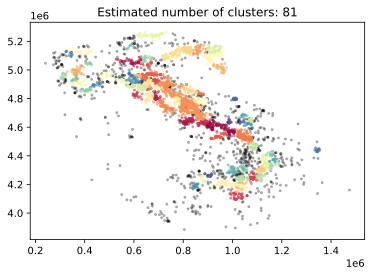

In [147]:
# ----------
# DBMSCAN
# ----------

eps = 0.02 # 0.1
min_samples = 10 # 30

db = DBSCAN(eps, min_samples, 'precomputed').fit(DISTANCES)

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

k = -1
col = [0, 0, 0, 1]
class_member_mask = (labels == k)

xy = df[class_member_mask & core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.25)

xy = df[class_member_mask & ~core_samples_mask]
plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.25)

for k, col in zip(unique_labels, colors):
    if k == -1:
        break

    class_member_mask = (labels == k)

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.5)

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(xy['X'],xy['Y'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters_}')
plt.show()

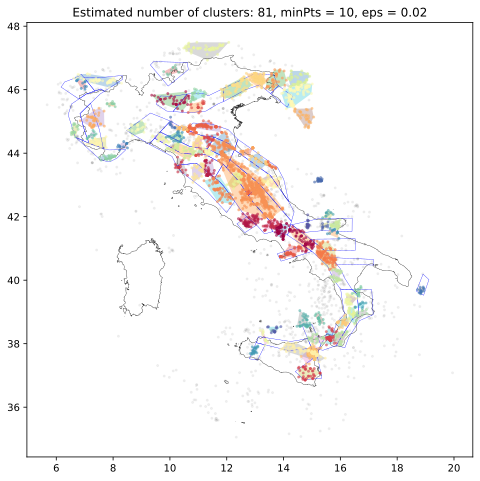

In [148]:
from scipy.spatial import ConvexHull
import matplotlib.cm as cm

clusts = labels
cmap = cm.get_cmap("hsv", len(np.unique(clusts)))


fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
# plt.scatter(df[['LonDef']], df[['LatDef']], c=clusts, cmap=plt.cm.viridis, alpha=1, s=10)
k = -1
col = [0, 0, 0, 1]
class_member_mask = (labels == k)

plot_shape(zones,'black')
plot_shape(zones_ZS9,'blue')

xy = df[class_member_mask & core_samples_mask]
plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.05)

xy = df[class_member_mask & ~core_samples_mask]
plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
        markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.05)
for k, col in zip(unique_labels, colors):
    if k == -1:
        break

    class_member_mask = (labels == k)

    xy = df[class_member_mask & core_samples_mask]
    plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.5)

    xy = df[class_member_mask & ~core_samples_mask]
    plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
             markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.5)
# plot centers
# plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# draw enclosure
for i in unique_labels:
    if i != -1:
      points = df[clusts == i][['LonDef','LatDef']].values
      #print(f'cluster {i} - number of points: {len(points)}')
      # get convex hull
      if len(points) > 2:
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                          points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                          points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3)
plt.title(f'Estimated number of clusters: {n_clusters_}, minPts = {min_samples}, eps = {eps}')
plt.show()
    
# plt.xlim(0,200)
# plt.ylim(0,200)

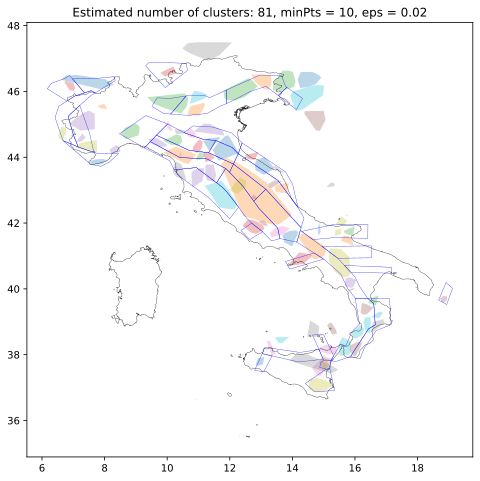

In [149]:
from scipy.spatial import ConvexHull
import matplotlib.cm as cm

clusts = labels
cmap = cm.get_cmap("hsv", len(np.unique(clusts)))


fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
# plt.scatter(df[['LonDef']], df[['LatDef']], c=clusts, cmap=plt.cm.viridis, alpha=1, s=10)
# k = -1
# col = [0, 0, 0, 1]
# class_member_mask = (labels == k)

plot_shape(zones,'black')
plot_shape(zones_ZS9,'blue')

# xy = df[class_member_mask & core_samples_mask]
# plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
#         markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.05)

# xy = df[class_member_mask & ~core_samples_mask]
# plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
#         markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.05)
# for k, col in zip(unique_labels, colors):
#     if k == -1:
#         break

#     class_member_mask = (labels == k)

#     xy = df[class_member_mask & core_samples_mask]
#     plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
#              markeredgecolor=tuple(col), linewidth=1, markersize=2, alpha=0.5)

#     xy = df[class_member_mask & ~core_samples_mask]
#     plt.plot(xy['LonDef'],xy['LatDef'], 'o', markerfacecolor=tuple(col),
#              markeredgecolor=tuple(col), linewidth=1, markersize=2,alpha=0.5)
    

# plot centers
# plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# draw enclosure
for i in unique_labels:
    if i != -1:
      points = df[clusts == i][['LonDef','LatDef']].values
      #print(f'cluster {i} - number of points: {len(points)}')
      # get convex hull
      if len(points) > 2:
        hull = ConvexHull(points)
        # get x and y coordinates
        # repeat last point to close the polygon
        x_hull = np.append(points[hull.vertices,0],
                          points[hull.vertices,0][0])
        y_hull = np.append(points[hull.vertices,1],
                          points[hull.vertices,1][0])
        # plot shape
        plt.fill(x_hull, y_hull, alpha=0.3)
plt.title(f'Estimated number of clusters: {n_clusters_}, minPts = {min_samples}, eps = {eps}')
plt.show()
    
# plt.xlim(0,200)
# plt.ylim(0,200)

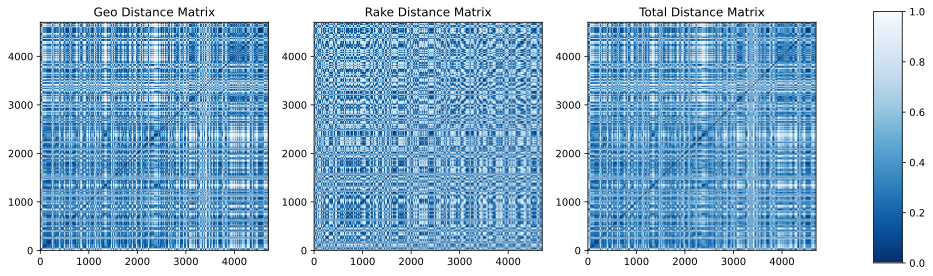

In [165]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
heatmap = ax[0].imshow(DISTANCES_utm_norm, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[0].title.set_text('Geo Distance Matrix')
heatmap = ax[1].imshow(DISTANCES_rake_norm, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[1].title.set_text('Rake Distance Matrix')
heatmap = ax[2].imshow(DISTANCES, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[2].title.set_text('Total Distance Matrix')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
_ = fig.colorbar(heatmap, cax=cbar_ax)

In [167]:
tot_points = []

for i in unique_labels:
    if i != -1:
        n_points = len(df[clusts == i].index.values)
        tot_points.append(n_points)

tot_points = np.array(tot_points)

sorted_idx = np.argsort(tot_points)
sorted_idx = sorted_idx[::-1]
tot_points[sorted_idx]

array([639, 200, 134, 125, 122, 117, 114,  89,  83,  76,  76,  75,  73,
        70,  69,  68,  64,  60,  57,  52,  51,  47,  42,  42,  41,  39,
        39,  37,  34,  34,  33,  31,  31,  30,  28,  28,  28,  28,  27,
        27,  27,  27,  26,  26,  25,  24,  23,  23,  23,  22,  21,  21,
        20,  20,  20,  20,  20,  19,  19,  18,  17,  17,  15,  15,  14,
        14,  12,  12,  12,  12,  11,  11,  10,  10,  10,  10,  10,  10,
        10,  10,   9])

In [168]:
unique_labels = np.array(list(unique_labels))
unique_labels[sorted_idx]

array([21, 28, 39, 18, 31, 37, 26, 20,  0, 14,  4,  1, 13, 32,  9, 19, 47,
        3, 40, 51, 50, 16, 24,  2, 10, 22,  8,  6, 25, 34, 29, 45, 59, 56,
       23, 38, 43, 15, 52, 49, 44, 67, 30, 55, 54,  7, 70, 33, 60, 27, 72,
       41, 11, 65, 48, 77, 58, 42, 17, 80, 57, 46, 35, 12, 75, 79,  5, 68,
       71, 62, 74, 64, 69, 53, 76, 63, 73, 36, 66, 61, 78])

In [174]:
clusters = []

idx = df[clusts == -1].index.values # noise points
for x in idx:
    clusters.append(x)

for i in unique_labels[sorted_idx]:
    if i != -1:
      idx = df[clusts == i].index.values
      for x in idx:
          clusters.append(x)

In [175]:
X_CL = X_ALL[clusters]
Y_CL = Y_ALL[clusters]


DISTANCES_utm_cl = np.array([distance_np(x, y, X_CL, Y_CL) for x, y in zip(X_CL,Y_CL)])

max_dist_utm_cl = 1000
DISTANCES_utm_norm_cl = DISTANCES_utm_cl / max_dist_utm_cl
DISTANCES_utm_norm_cl = np.array([[di if di <= 1 else 1 for di in d] for d in DISTANCES_utm_norm_cl])

In [176]:
RAKE_CL = RAKE_ALL[clusters]

#RAKE_ALL = (RAKE_ALL - np.mean(RAKE_ALL)) / np.std(RAKE_ALL)

DISTANCES_rake_cl = np.array([rake_distance(r, RAKE_CL) for r in RAKE_CL])

max_dist_rake = 180

DISTANCES_rake_norm_cl = DISTANCES_rake_cl / max_dist_rake
DISTANCES_rake_norm_cl = np.array([[di if di <= 1 else 1 for di in d] for d in DISTANCES_rake_norm_cl])

# max_dist_rake = max(list(map(max, *DISTANCES_rake_norm)))
# print(max_dist_rake)

In [177]:
DISTANCES_cl = alpha * DISTANCES_utm_norm_cl + DISTANCES_rake_norm_cl

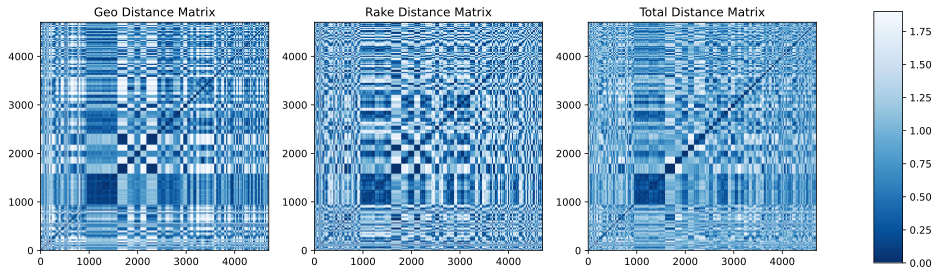

In [178]:
fig, ax = plt.subplots(1,3, figsize=(16,5))
heatmap = ax[0].imshow(DISTANCES_utm_norm_cl, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[0].title.set_text('Geo Distance Matrix')
heatmap = ax[1].imshow(DISTANCES_rake_norm_cl, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[1].title.set_text('Rake Distance Matrix')
heatmap = ax[2].imshow(DISTANCES_cl, cmap='Blues_r', interpolation='nearest', origin='lower')
ax[2].title.set_text('Total Distance Matrix')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
_ = fig.colorbar(heatmap, cax=cbar_ax)